In [1]:
import pandas as pd
import os
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
from torch.utils.data import DataLoader
from skopt import BayesSearchCV
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, f1_score
from skopt.space import Integer

In [2]:
# fix seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# Preprocess and clean data
def clean_df(df, test=False):
    
    # Drop PassengerId and Name
    df.drop('PassengerId', axis='columns', inplace=True)
    df.drop('Name', axis='columns', inplace=True)

    # Cabin dictionary, char to int
    cabin_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6,
    'G':7,
    'H':8,
    'T':9
    }

    # Change cabin value just to numbers, ex.  B36 -> 236
    # Iterate by rows
    for c_i, cabin in enumerate(df['Cabin']):
        # Change only value with str datatype, 
        if not isinstance(cabin,str):
            continue
        # Iterate by row value
        for n_i ,char in enumerate(cabin):
            # Start iterating from last to first char
            index = -1 - n_i
            # If given char in cabin dictionary
            if cabin[index] in cabin_dict.keys():
                # Cabin letter to ID
                cabin_letter_id = str(cabin_dict[cabin[index]])
                # Cabin number
                cabin_number = str(df['Cabin'][c_i][index+1:])
                # If cabin number == cabin letter put empty value
                if cabin_number in cabin_dict.keys(): cabin_number = ''
                # Join letter with number and change that value in dataframe
                df.loc[c_i, 'Cabin'] =  int(cabin_letter_id + cabin_number)
                break

    # Change cabing datatype to float
    df['Cabin'] = (df['Cabin']).astype(float)

    # Change ticket value just to numbers
    # Iterate by rows
    for t_i, ticket in enumerate(df['Ticket']):
        # If ticket value == LINE change to 0
        if ticket == 'LINE':
            df.loc[t_i, 'Ticket'] = 0
        # Iterate by row value
        for c_i ,char in enumerate(ticket):
            # Start iterating from last to first char
            index = -1 - c_i
            # If whitespace found 
            if ticket[index] == ' ':
                # Change value to numbers after whitespace
                df.loc[t_i, 'Ticket'] = df['Ticket'][t_i][index+1:]   
                break
        continue

    # Reset dataframe indexing
    df.reset_index()

    # Embarked dictionary, char to int
    embarked_dict = {
    'C':0,
    'Q':1,
    'S':2
    }

    # Sex dictionary, str to int
    sex_dict = {
        'male':0,
        'female':1
    }

    # Replace values in dataframe with dictionaries
    df.replace({'Sex':sex_dict}, inplace=True)
    df.replace({'Embarked':embarked_dict}, inplace=True)

    # Fill na values with mean
    df.fillna(
                {
                'Age': df['Age'].mean(),
                'Cabin': df['Cabin'].mean(),
                'Embarked': df['Embarked'].mean()
                },
                inplace=True
                ) 
    
    # If training data save temporary column
    if not test:
        df_y = df['Survived']
        df_y= (df_y).astype(float)
        # drop survived from dataframe
        df.drop('Survived', axis='columns', inplace=True)
    
    # drop rows with empty Ticket value
    df = df[df.Ticket != '']
    # Change Ticket datatype
    df['Ticket'] = (df['Ticket']).astype(float)

    # Change dataframe values range from 0 to 1
    df=(df-df.min())/(df.max()-df.min())

    # If training join Survived column
    if not test:
        df = df.join(df_y)

    return df

In [ ]:
# Load data
# Train
DATA_PATH = 'data'
train_data_path = os.path.join(DATA_PATH,'train.csv')
train_df = pd.read_csv(train_data_path, sep=',')

# Test
test_data_path = os.path.join(DATA_PATH,'test.csv')
test_df = pd.read_csv(test_data_path, sep=',')

# Preprocess data
train_df = clean_df(train_df)
test_df = clean_df(test_df, test=True)
train_df = train_df.to_numpy()
test_df = test_df.to_numpy()

# Split data
train_set, val_set = torch.utils.data.random_split(train_df, [700, 191])

# Create dataloaders
batach_size = 16
train_dataloader = DataLoader(dataset=train_set, batch_size=batach_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_set, batch_size=batach_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_df, batch_size=batach_size, shuffle=False)

In [5]:
# Model for preditions
class Linear_logistic_titanic(torch.nn.Module):

  # define model
  def __init__(self):
    super(Linear_logistic_titanic, self).__init__()
    self.regression = torch.nn.Linear(9,2,dtype=float)

  # define forward
  def forward(self, x):
    x = self.regression(x)
    x = torch.sigmoid(x)
    return x

In [6]:
# create model
model = Linear_logistic_titanic()

In [7]:
# define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# define optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0009976160848023435)

# set model to train
model.train()

# set number of training epochs
EPOCHS = 15

# define training variables
running_loss = 0
history = []

# training loop
for epoch in range(EPOCHS):
  print('Epoch:', epoch)
  for i,batch in enumerate(train_dataloader):
    x,y = batch[:,:-1],batch[:,-1]
    pred = model(x)
    y = y.type(torch.int64)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    history.append(loss.item())
    # print loss every 100 batches
    if i % 10 == 99:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        running_loss = 0.

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


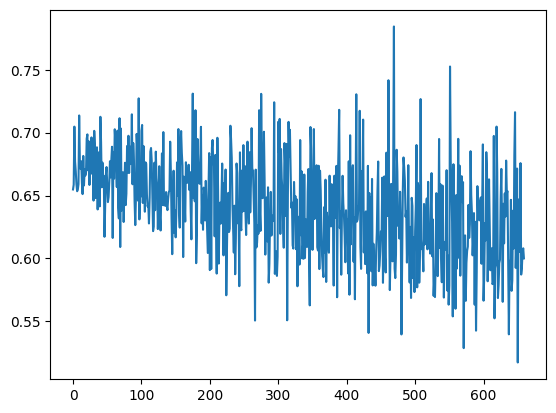

In [8]:
# plot training dataset loss
plt.plot(history)

In [9]:
# set model for evaluation
model.eval()

# define variables for evaluation
outputs = []
labels = []

# evaluation loop
for batch in val_dataloader:
  x,y = batch[:,:-1],batch[:,-1]
  y = y.type(torch.int64)
  pred = model(x)
  pred = torch.argmax(pred,dim=1).detach().numpy()
  outputs.extend(pred)
  labels.extend(y)

In [10]:
# calculate evaluation metrics
acc = accuracy_score(labels, outputs)
f1 = f1_score(labels, outputs, average='weighted')

print('Accuracy:', acc)
print('F1:', f1)

Accuracy: 0.6596858638743456
F1: 0.5817999218452209


In [11]:
# Place model in sklearn environment
net = NeuralNetClassifier(
    Linear_logistic_titanic,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net.set_params(train_split=False, verbose=0)

# Define param space
param_space = {
    'lr': (1e-6, 1, 'log-uniform'),
    'max_epochs': Integer(1, 20),
    'batch_size': Integer(2,64)

}

# Initialize Bayesian Optimization
opt = BayesSearchCV(
    net,
    param_space,
    n_iter=32,
    cv=3
)

# Prepera data for sklearn training
train_set = np.array(train_set)
val_set = np.array(val_set)
X_train,y_train = train_set[:,:-1],train_set[:,-1]
X_test,y_test = val_set[:,:-1],val_set[:,-1]
y_train = y_train.astype(int)

In [ ]:
# train model
opt.fit(X_train, y_train)

In [13]:
opt.best_params_

OrderedDict([('batch_size', 2),
             ('lr', 0.1082448942690678),
             ('max_epochs', 20)])

In [14]:
# Train model with hyperparameters from BayesSearch
# create dataloader
batch_size = opt.best_params_['batch_size']
train_dataloader = DataLoader(dataset=train_set, batch_size=batach_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_set, batch_size=batach_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_df, batch_size=batach_size, shuffle=False)

# create model
model = Linear_logistic_titanic()

# define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# define optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=opt.best_params_['lr'])

# set model to train
model.train()

# set number of training epochs
EPOCHS = opt.best_params_['max_epochs']

# define training variables
running_loss = 0
history = []

# training loop
for epoch in range(EPOCHS):
  print('Epoch:', epoch)
  for i,batch in enumerate(train_dataloader):
    x,y = batch[:,:-1],batch[:,-1]
    pred = model(x)
    y = y.type(torch.int64)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    history.append(loss.item())
    # print loss every 100 batches
    if i % 10 == 99:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        running_loss = 0.

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


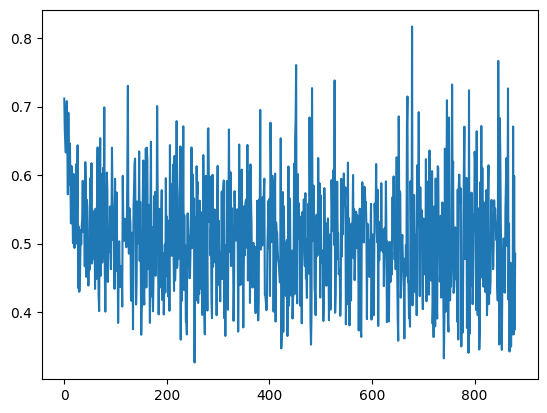

In [15]:
# plot training dataset loss
plt.plot(history)

In [16]:
# set model for evaluation
model.eval()

# define variables for evaluation
outputs = []
labels = []

# evaluation loop
for batch in val_dataloader:
  x,y = batch[:,:-1],batch[:,-1]
  y = y.type(torch.int64)
  pred = model(x)
  pred = torch.argmax(pred,dim=1).detach().numpy()
  outputs.extend(pred)
  labels.extend(y)

In [17]:
# calculate evaluation metrics
acc = accuracy_score(labels, outputs)
f1 = f1_score(labels, outputs, average='weighted')

print('Accuracy:', acc)
print('F1:', f1)

Accuracy: 0.8324607329842932
F1: 0.828124769559767
